# Nested sampling for bayesian analysis of phases distributions

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

## Import phases from file on disk

Th file has rows with 16 different columns, one for each measured phase.
The number of rows is the number of lattice configurations used for the measurements.

In [3]:
# phases = pd.read_csv("EK_D3N16M16S32T0290_phase_1.txt", sep="\s+", header=None)
# phases = pd.read_csv("EK_D3N24M24S32T0290_phase_1.txt", sep="\s+", header=None)
phases = pd.read_csv("EK_D3N32M32S32T0290_phase_1.txt", sep="\s+", header=None)


In [4]:
phases.columns = [f"theta{i}" for i in phases.columns]

In [5]:
phases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4010 entries, 0 to 4009
Data columns (total 32 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   theta0   4010 non-null   float64
 1   theta1   4010 non-null   float64
 2   theta2   4010 non-null   float64
 3   theta3   4010 non-null   float64
 4   theta4   4010 non-null   float64
 5   theta5   4010 non-null   float64
 6   theta6   4010 non-null   float64
 7   theta7   4010 non-null   float64
 8   theta8   4010 non-null   float64
 9   theta9   4010 non-null   float64
 10  theta10  4010 non-null   float64
 11  theta11  4010 non-null   float64
 12  theta12  4010 non-null   float64
 13  theta13  4010 non-null   float64
 14  theta14  4010 non-null   float64
 15  theta15  4010 non-null   float64
 16  theta16  4010 non-null   float64
 17  theta17  4010 non-null   float64
 18  theta18  4010 non-null   float64
 19  theta19  4010 non-null   float64
 20  theta20  4010 non-null   float64
 21  theta21  4010 

In [6]:
phases.sample(2)

,theta0,theta1,theta2,theta3,theta4,theta5,theta6,theta7,theta8,theta9,...,theta22,theta23,theta24,theta25,theta26,theta27,theta28,theta29,theta30,theta31
2803,-2.907007,0.577986,0.822015,1.819109,-1.408930,0.960511,0.250007,0.466196,-0.102942,0.021233,...,-1.740898,0.633618,0.134877,-1.004483,1.254626,2.374003,-0.659588,-1.577239,1.667792,-1.912264
1688,-2.436040,0.774885,1.003986,2.464189,-0.856044,1.277620,0.570502,0.677499,0.146423,0.256801,...,-1.254556,0.958696,0.395205,-0.578818,1.730890,-2.679078,-0.427312,-1.197921,2.141044,-1.542299


<AxesSubplot:>

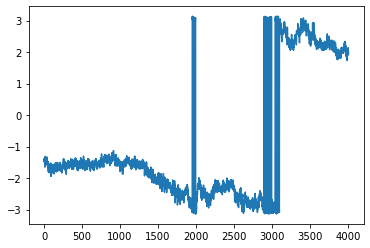

In [7]:
phases['theta0'].plot()

<AxesSubplot:>

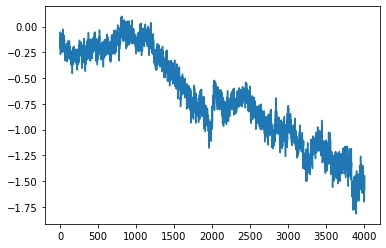

In [8]:
phases['theta15'].plot()

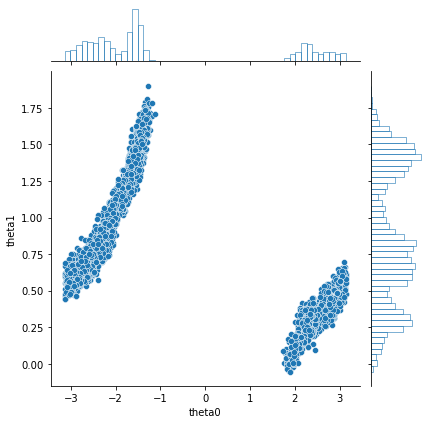

In [9]:
sns.jointplot(x='theta0', y='theta1', data=phases, marginal_kws=dict(bins=50, fill=False))

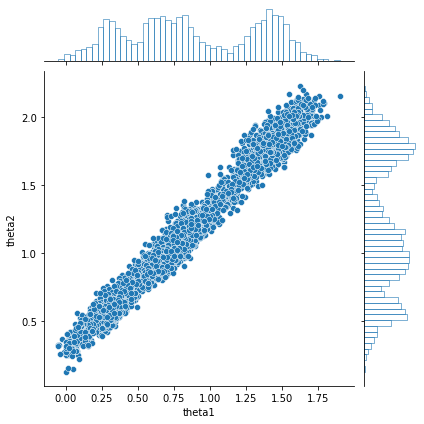

In [10]:
sns.jointplot(x='theta1', y='theta2', data=phases, marginal_kws=dict(bins=50, fill=False))

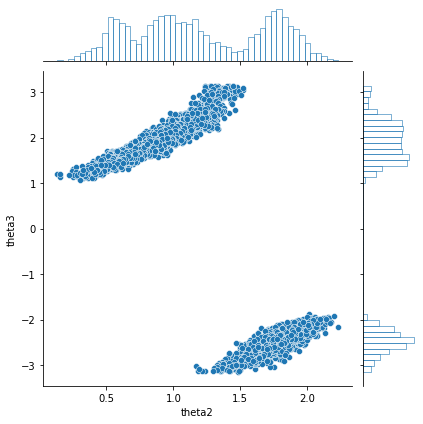

In [11]:
sns.jointplot(x='theta2', y='theta3', data=phases, marginal_kws=dict(bins=50, fill=False))

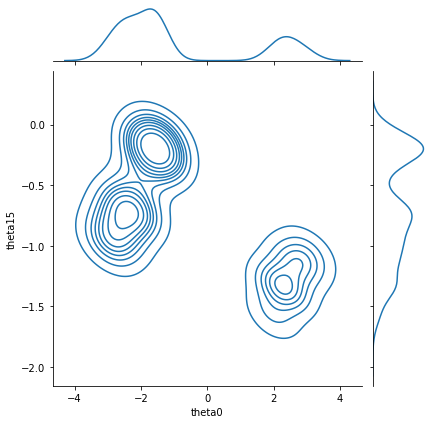

In [12]:
sns.jointplot(x='theta0', y='theta15', data=phases, kind='kde')

Create an histogram for entire dataset of phases.

In [13]:
alphas = phases.values.flatten()

In [14]:
print(f"We have a total of {alphas.shape[0]} phases")

We have a total of 128320 phases


Fold the distribution by taking the absolute value

In [15]:
alphas_folded = np.fabs(alphas)

<AxesSubplot:ylabel='Count'>

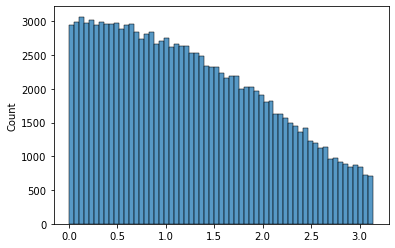

In [16]:
sns.histplot(data=alphas_folded)

<AxesSubplot:ylabel='Density'>

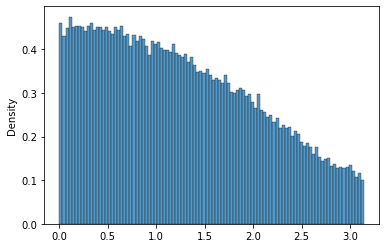

In [17]:
sns.histplot(data=alphas_folded, bins=100, stat='density')

Effects ot different bandwidths when doing kernel density estimations with a mixture of gaussians

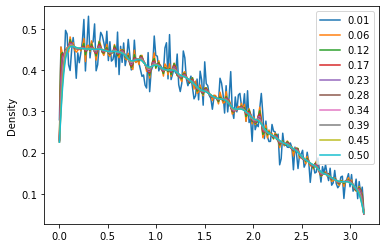

In [18]:
fig, ax = plt.subplots()
for bw in np.linspace(0.01,0.5,10):
  sns.kdeplot(data=alphas_folded, cut=0, clip=[0.0,np.pi], bw_adjust=bw, label=f"{bw:.2f}", ax=ax)
plt.legend(loc='upper right')

## Fit the probability distribution based on Fourier expansion

We use this as our model for the probability distribution of $\alpha$ with unknown coefficients $\tilde{\rho}_k$:

$$\rho(\alpha)=\frac{1}{2 \pi}+\sum_{k=1}^{\infty} \tilde{\rho}_{k} \cos (k \alpha)$$

Choose the number of parameters and their names based on how many Fourier coefficients to keep:

In [19]:
Nf = 5  # number of Fourier coefficient
parameters = [f"k{i+1}" for i in np.arange(Nf)]

def prior_transform(cube):
    # the argument, cube, consists of values from 0 to 1
    # we have to convert them to physical scales
    params = cube.copy()
    # all parameters should around 0: change the limits if needed
    lo = -0.1
    hi = 0.1
    params[:] = cube[:] * (hi - lo) + lo
    return params

In [20]:
parameters

['k1', 'k2', 'k3', 'k4', 'k5']

Define the model above

In [21]:
alpha = np.random.rand(10)
params = np.random.rand(Nf)
fourier_terms = np.array([params[k]*np.cos((k+1)*alpha) for k in np.arange(Nf)])

In [22]:
fourier_terms.shape

(5, 10)

In [23]:
prob = fourier_terms.sum(axis=0)+1./(2.*np.pi)

In [24]:
if (prob < 0).any():
  print("Some are negative")

Some are negative


Make sure to only keep positive probabilities

In [25]:
def prob_model(alpha,params):
  fourier_terms = np.array([params[k]*np.cos((k+1)*alpha) for k in np.arange(Nf)])
  prob = 1./(2.*np.pi) + fourier_terms.sum(axis=0)  # the k=0 term is 1/2pi
  if (prob < 0).any():  # if some probs are negative, the total prob is 0
    return np.zeros_like(prob)
  return prob

In [26]:
prob_model(np.random.rand(1),np.random.rand(Nf))

array([3.20422445])

In [27]:
prob_model(np.random.rand(2),np.random.rand(Nf))

array([0.0196211 , 1.61084064])

This likelihood ignores the correlations between differen $\alpha$ values. We define it as:

$$ \mathcal{L} \propto \prod_{n=1}^{n_{\text {config }}} \prod_{i=1}^{N} \rho\left(\alpha_{i}^{(n)}\right) $$

In [28]:
def log_likelihood(params):
    # compute the probability for each alpha point
    probs_alphas = prob_model(alphas,params)
    assert probs_alphas.shape[0] == alphas.shape[0]
    # the total probability is the product of the individual ones, we assume independent
    # for numerical stability, we work in log and avoid zeros
    loglike = np.log(probs_alphas + 1e-100).sum()
    return loglike

The log-likelihood is often ridiculously small (and negative) because the probabilities are zero hence the sum of logs is -$\infty$

In [29]:
log_likelihood(np.random.rand(Nf))

-29546771.91329959

If all parameters are set to zero, the probabilities do not depend on the data and are always equal to $1/2\pi$. This gives the following log-likelihood

In [30]:
log_likelihood(np.zeros(Nf))

-235836.3851616471

We can check if that is correct

In [31]:
# number of alphas
n_data = alphas.shape[0]
loglik = np.log([1/(2*np.pi)]*n_data).sum()
print(loglik)

-235836.3851616471


### Run the sampler

Define the reactive nested sampler

In [32]:
import ultranest

sampler = ultranest.ReactiveNestedSampler(parameters, log_likelihood, prior_transform)

If needed you can add a slice sampler for a more efficient sampling in high dimensions

In [33]:
# import ultranest.stepsampler

# # have to choose the number of steps the slice sampler should take
# # after first results, this should be increased and checked for consistency.

# nsteps = 2 * len(parameters)
# # create step sampler:
# sampler.stepsampler = ultranest.stepsampler.RegionSliceSampler(nsteps=nsteps)

In [34]:
results = sampler.run(min_num_live_points=400)

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+05  ..-226664.12 [-226664.3823..-226664.3817]*| it/evals=6147/18292 eff=33.3054% N=212  
[ultranest] Likelihood function evaluations: 18294
[ultranest]   logZ = -2.267e+05 +- 0.2305
[ultranest] Effective samples strategy satisfied (ESS = 1225.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.11 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 210 minimum live points (dlogz from 0.20 to 0.54, need <0.5)
[ultranest]   logZ error budget: single: 0.32 bs:0.23 tail:0.01 total:0.23 required:<0.50
[ultranest] done iterating.


### Plot results

In [35]:
sampler.print_results()


logZ = -226688.446 +- 0.538
  single instance: logZ = -226688.446 +- 0.234
  bootstrapped   : logZ = -226688.357 +- 0.538
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    k1                  : 0.07731│ ▁▁▁▁▁▁▁▁▁▂▃▃▅▆▅▇▇▇▇▇▇▇▅▅▃▃▂▁▁▁▁▁▁▁▁▁▁ │0.08184    0.07953 +- 0.00056
    k2                  : -0.01708│ ▁▁ ▁▁▁▁▁▁▁▂▂▃▄▅▆▇▇▇▇▆▆▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁ │-0.01197    -0.01450 +- 0.00061
    k3                  : 0.00208│ ▁ ▁ ▁ ▁▁▁▁▁▂▂▄▃▅▅▇▆▆▇▇▆▇▅▅▄▃▃▂▂▁▁▁▁▁▁ │0.00708    0.00484 +- 0.00062
    k4                  : -0.00459│ ▁▁▁▁▁▁▁▁▁▂▂▃▃▄▅▆▆▆▇▇▇▆▆▅▃▃▂▂▁▁▁▁▁▁▁▁▁ │0.00041    -0.00206 +- 0.00062
    k5                  : -0.00211│ ▁  ▁▁▁▁▁▁▁▂▂▃▃▄▅▇▇▇▇▇▇▅▅▄▃▂▃▂▁▁▁▁▁▁▁▁ │0.00290    0.00053 +- 0.00059



In [36]:
sampler.results

{'niter': 6362,
 'logz': -226688.44608517207,
 'logzerr': 0.5380735679545979,
 'logz_bs': -226688.3574710077,
 'logz_single': -226688.44608517207,
 'logzerr_tail': 0.009922746306983754,
 'logzerr_bs': 0.5379820662783459,
 'ess': 1225.1829536233606,
 'H': 21.91799764786265,
 'Herr': 0.22588702227408775,
 'posterior': {'mean': [0.07952544716883513,
   -0.0145005170432576,
   0.00484481603281706,
   -0.002064184797092474,
   0.0005253156389633779],
  'stdev': [0.0005634592945943535,
   0.0006104889823021717,
   0.0006203217479003007,
   0.0006225953747175214,
   0.0005856387778030109],
  'median': [0.07953256849416021,
   -0.014525868844551038,
   0.004832706348251392,
   -0.002042873586350996,
   0.0005131595117503912],
  'errlo': [0.0789590020573013,
   -0.015094039555928848,
   0.004187414457552207,
   -0.002701435375045472,
   -3.554150322676586e-05],
  'errup': [0.08008657573886493,
   -0.013866369058034261,
   0.005482260547525986,
   -0.0014535073343163452,
   0.0011090505576649284

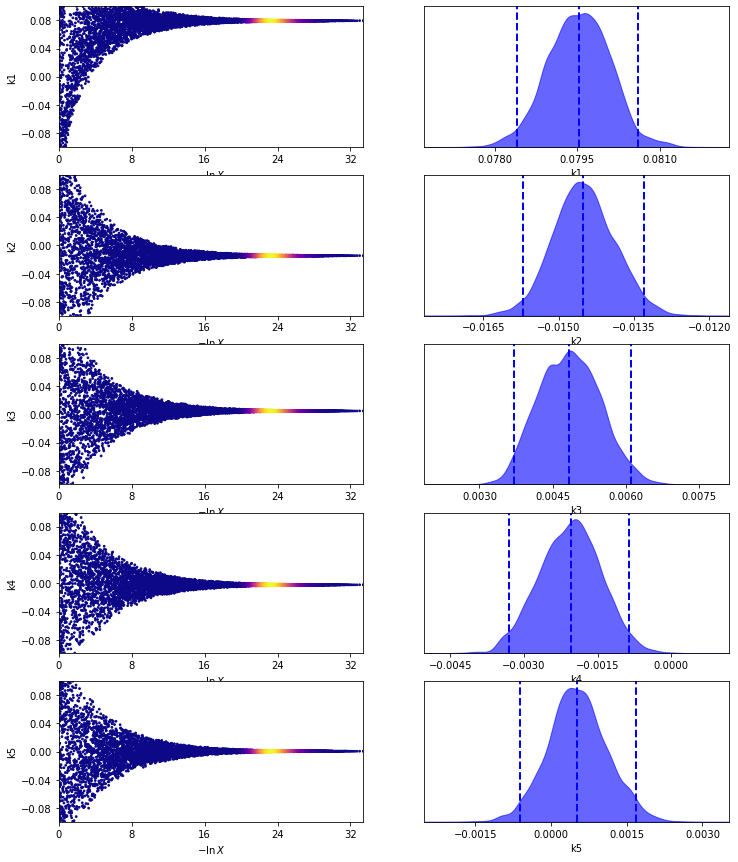

In [37]:
sampler.plot_trace()

In [38]:
from corner import corner
import arviz as az 
import xarray as xr 

df = pd.DataFrame(sampler.results['samples'], columns=parameters)
df["chain"] = 0
df["draw"] = np.arange(len(df), dtype=int)
df = df.set_index(["chain", "draw"])
xdata = xr.Dataset.from_dataframe(df)

dataset = az.InferenceData(posterior=xdata)

In [39]:
dataset

Inference data with groups:
	> posterior

array([[<AxesSubplot:title={'center':'k1'}>,
        <AxesSubplot:title={'center':'k2'}>,
        <AxesSubplot:title={'center':'k3'}>],
       [<AxesSubplot:title={'center':'k4'}>,
        <AxesSubplot:title={'center':'k5'}>, <AxesSubplot:>]],
      dtype=object)

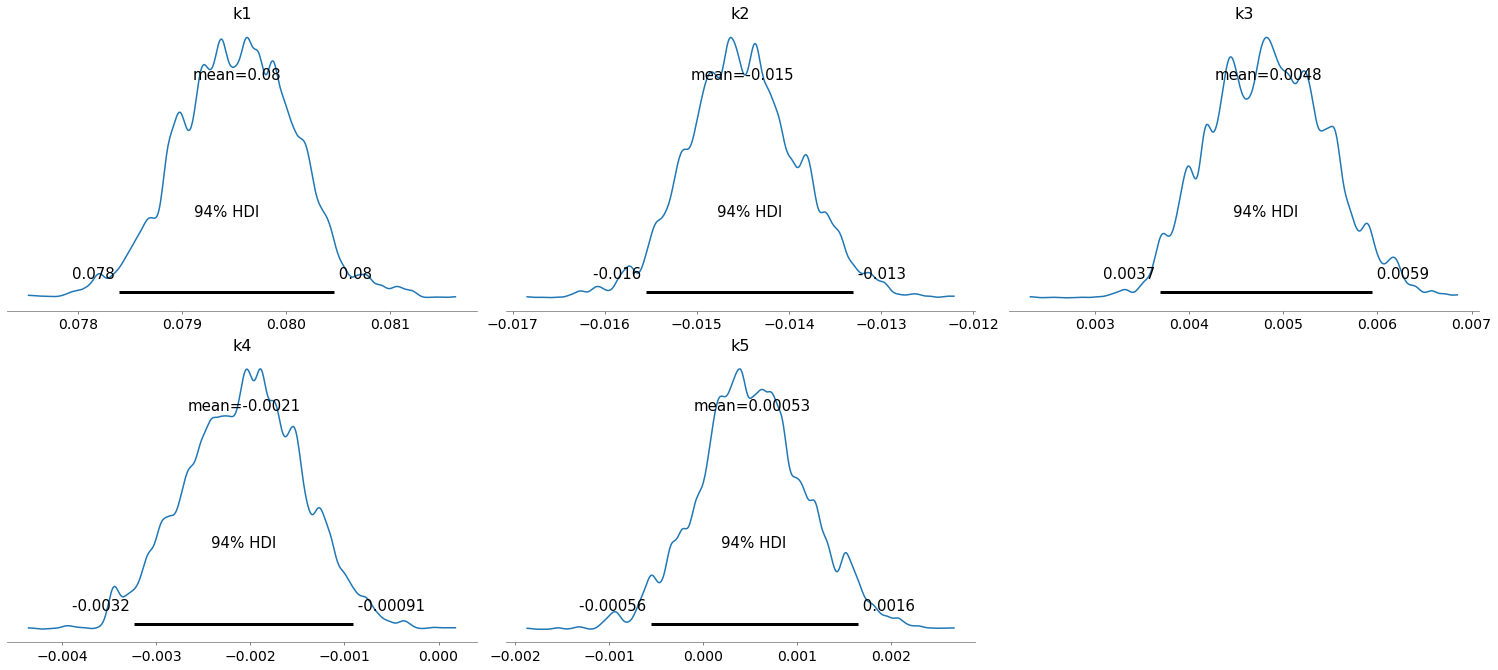

In [40]:
az.plot_posterior(dataset) # or choose only one parameter with var_names=['k1']

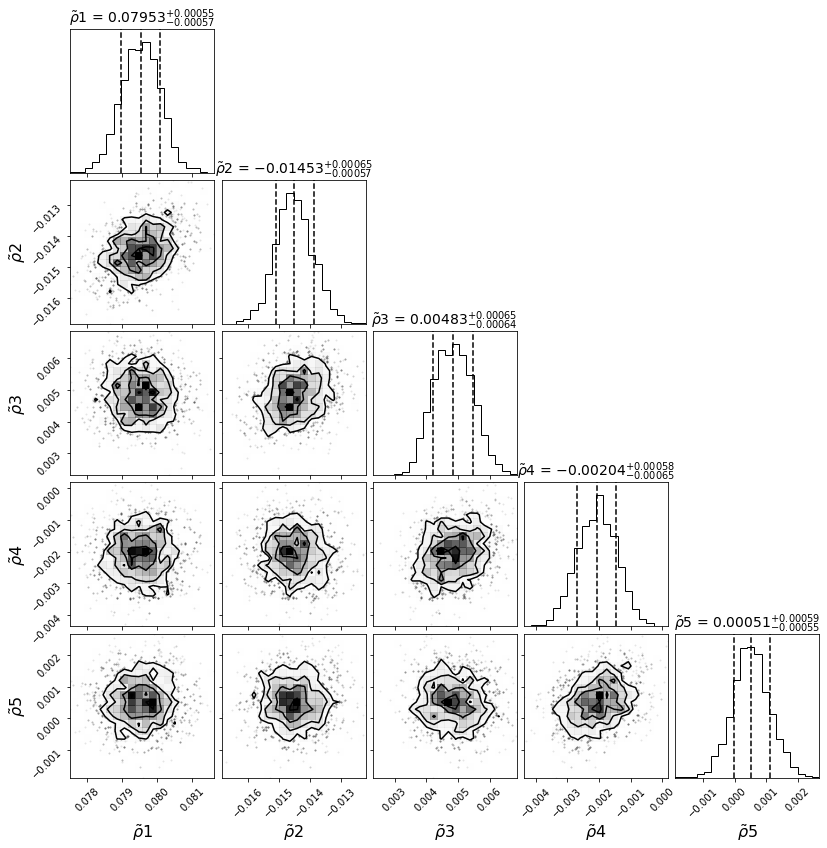

In [41]:
labels = [r'$\tilde{\rho}$'+f'{k+1}' for k in range(Nf)]
fig = corner(dataset, labels=labels, show_titles=True, title_fmt=".5f", quantiles=[0.16, 0.5, 0.84], title_kwargs={"fontsize": 14}, label_kwargs={"fontsize": 16})

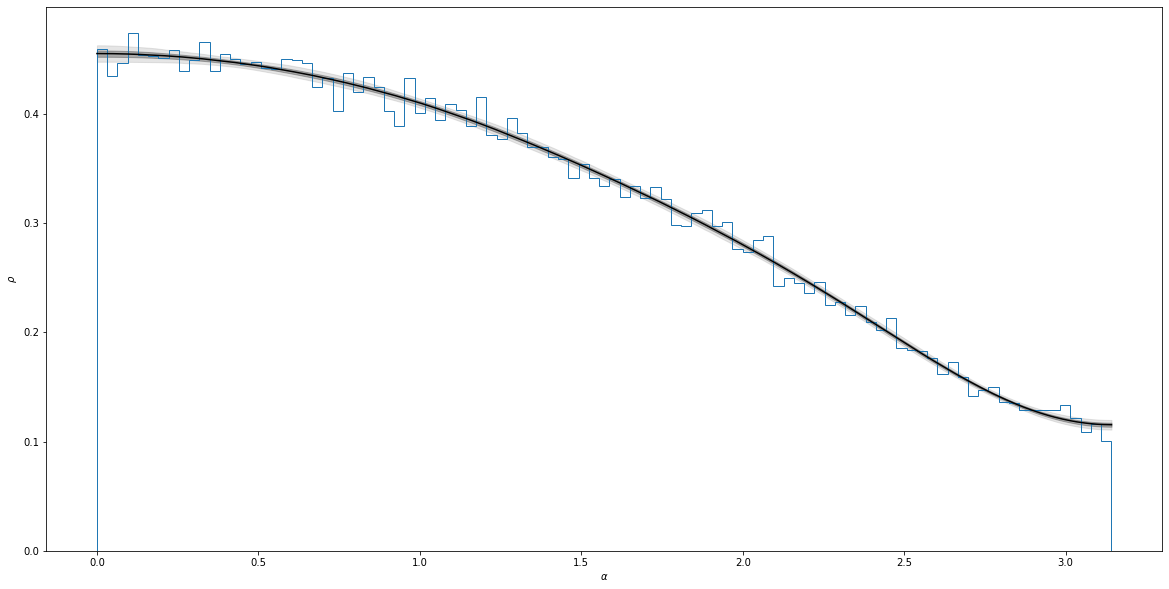

In [50]:
from ultranest.plot import PredictionBand
import matplotlib.pyplot as plt 

plt.figure(figsize=(20,10))
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\rho$')
bins = np.linspace(0, np.pi, 100)
plt.hist(alphas_folded,bins,density=True,histtype='step');

alpha_grid = np.linspace(0, np.pi, 500)
band = PredictionBand(alpha_grid)

# go through the solutions
for params in sampler.results['samples']:
    # compute for each time the probability from the model
    band.add(2*prob_model(alpha_grid,params))

band.line(color='k')
# add 1 sigma quantile
band.shade(color='k', alpha=0.3)
# add wider quantile (0.01 .. 0.99)
band.shade(q=0.49, color='gray', alpha=0.2)


## Extract the value of $\rho$ at $\pi$

Point a $\pi$ 

In [49]:
band.x[-1]-np.pi

0.0

Take all the samples at the value of $\pi$ (remember that we saved 2$\rho$ in the prediction band)

In [44]:
rhopi = np.asarray([rho[-1]/2 for rho in band.ys])

<AxesSubplot:ylabel='Density'>

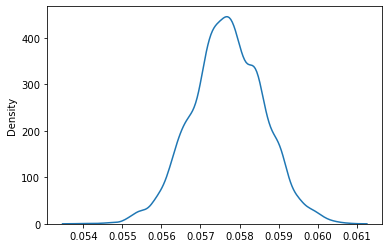

In [53]:
sns.kdeplot(data=rhopi)

In [46]:
print(f"Value of rho(pi) = {rhopi.mean():.5f} +- {rhopi.std():.5f}")

Value of rho(pi) = 0.05769 +- 0.00092


In [47]:
errs = np.diff(np.quantile(rhopi,[0.16,0.5,0.84]))
print(f"Value of rho(pi) = {rhopi.mean():.5f} + {errs[1]:.5f} - {errs[0]:.5f}")

Value of rho(pi) = 0.05769 + 0.00091 - 0.00092


Pretty formatting

In [48]:
from IPython.display import display, Math

mcmc = np.percentile(rhopi, [16, 50, 84])
q = np.diff(mcmc)
txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
txt = txt.format(mcmc[1], q[0], q[1], '\\rho(\pi)')
display(Math(txt))

<IPython.core.display.Math object>